In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-12-25 15:32:42.685205: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [5]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply

def create_model(input_shape=(64, 64, 15)):

    depths=[3, 3, 27, 3]
    projection_dims=[32, 64, 96, 128]
    drop_path_rate=0.0
    layer_scale_init_value=1e-6


    model_name='Branch64X'
    IN64 = layers.Input(shape=input_shape)
    X = IN64

    # X = layers.LocallyConnected2D(32, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
    # X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc1_norm".format(model_name))(X)
    # X = layers.Activation("gelu", name="{}_lc1_gelu".format(model_name))(X)

    # X = layers.LocallyConnected2D(96, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
    # X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc2_norm".format(model_name))(X)
    # X = layers.Activation("gelu", name="{}_lc2_gelu".format(model_name))(X)

    # ----- convnext block 0 ----- #

    X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

    for j in range(depths[0]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                                   groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext


    # ----- convnext block 1 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

    for j in range(depths[1]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                                   groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    # ----- convnext block 2 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

    for j in range(depths[2]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=5, padding="same",
                                   groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    # ----- convnext block 3 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

    for j in range(depths[3]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=5, padding="same",
                                   groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    V1 = X

    OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
    OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

    OUT = layers.Dense(64, name="{}_dense1".format(model_name))(OUT)
    OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
    OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

    OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

    model = Model(inputs=IN64, outputs=OUT, name=model_name)

    return model

In [6]:
def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [7]:
# from importlib import reload
# reload(ck)

In [8]:
#ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
L_vars = len(ind_pick_from_batch)

In [9]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*pos*.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*pos*.npy"))

print('neg:{} vs pos:{}'.format(len(filename_neg_train), len(filename_pos_train)))

neg:6739773 vs pos:27551


In [16]:
filename_valid = filename_neg_valid[::800] + filename_pos_valid[::2]
#filename_valid = filename_neg_valid[::200] + filename_pos_valid[::50]
print(len(filename_valid))

L_valid = len(filename_valid)

VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
VALID_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        VALID_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            VALID_target[i] = 1.0
        else:
            VALID_target[i] = 0.0

12410


In [17]:
np.sum(VALID_target) / len(VALID_target)

0.6929895245769541

**ConvNext**

In [18]:
#tf.config.list_physical_devices('GPU')

In [ ]:
training_rounds = 20

seeds = [12342, 2536234, 98765, 473, 865, 7456, 69472, 3456357, 3425, 678,
         2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695]
# seeds = [473, 865, 7456, 69472, 3456357, 3425, 678,
#          2452624, 5787, 235362, 67896, 98454, 12445, 46767, 78906, 345, 8695]

min_del = 0
max_tol = 1000 # early stopping with patience

epochs = 500
batch_size = 200
L_train = 64 #int(len(TRAIN_Y_pick) / batch_size)

X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
Y_batch[...] = np.nan

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# =========== Model Section ========== #
key = 'RE0_15p'
model_name = '{}_copy1'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = 0.14773765787876958 #0.021237620777840503 #0.05669766786174394 #0.08634155630837792
print("Initial record: {}".format(record))

count = 0


for r in range(training_rounds):
    
    tol = 0 - count - r
    
    #flag_count_change = True
    
    model = create_model(input_shape=(64, 64, 15))
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=5e-5))
    
    W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1/')
    model.set_weights(W_old)
    
    set_seeds(seeds[r+1])
    print('Training round {}'.format(r))
    
    for i in range(epochs):
    
        #backend.set_value(model.optimizer.learning_rate, learning_rate[i])
        
        #print('epoch = {}'.format(i))
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            
            N_pos = 20
            N_neg = batch_size - N_pos
            
            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)
        
            file_pick_neg = []
            for ind_temp in ind_neg[:N_neg]:
                file_pick_neg.append(filename_neg_train[ind_temp])

            file_pick_pos = []
            for ind_temp in ind_pos[:N_pos]:
                file_pick_pos.append(filename_pos_train[ind_temp])
        
            file_pick = file_pick_neg + file_pick_pos
            
            if len(file_pick) != batch_size:
                sregwet
        
            for k in range(batch_size):
                data = np.load(file_pick[k])
                
                for l, c in enumerate(ind_pick_from_batch):
                    temp = data[..., c] 
                    X_batch_64[k, ..., l] = temp
                    
                if 'pos' in file_pick[k]:
                    Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
                elif 'neg_neg_neg' in file_pick[k]:
                    Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
                else:
                    werhgaer
                    
            ind_ = du.shuffle_ind(batch_size)
            X_batch_64 = X_batch_64[ind_, ...]
            Y_batch = Y_batch[ind_, :]
            
            # train on batch
            model.train_on_batch(X_batch_64, Y_batch);
            
        # epoch end operations
        Y_pred = model.predict([VALID_input_64])
        # Y_pred[Y_pred<0] = 0
        # Y_pred[Y_pred>1] = 1
        
        Y_pred = 1/(1 + np.exp(-Y_pred))
        
        record_temp = verif_metric(VALID_target, Y_pred)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del) and np.max(Y_pred)>0.6:
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp >= 2.0:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    if tol == 1 and i > count:
                        #flag_count_change = False
                        count = i
                        print(count)
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 0.14773765787876958
Training round 0
0.15379064799591938
Validation loss 0.15379064799591938 NOT improved
0.15008088093535568
Validation loss 0.15008088093535568 NOT improved
0.1648935488948798
Validation loss 0.1648935488948798 NOT improved
0.161308981429507
Validation loss 0.161308981429507 NOT improved
0.1478961333133825
Validation loss 0.1478961333133825 NOT improved
0.16093034189693142
Validation loss 0.16093034189693142 NOT improved
0.14558665458659764
Validation loss improved from 0.14773765787876958 to 0.14558665458659764
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1/assets
--- 450.5101580619812 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.15448206613458437
Validation loss 0.15448206613458437 NOT improved
7
0.14362894439003218
Validation loss improved from 0.14558665458659764 to 0.14362894439003218
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1/assets
--- 479.1280429363251 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.15002764141544456
Validation loss 0.15002764141544456 NOT improved
9
0.1572788734959857
Validation loss 0.1572788734959857 NOT improved
0.15329918229867978
Validation loss 0.15329918229867978 NOT improved
0.14400249709567745
Validation loss 0.14400249709567745 NOT improved
0.14803522208075015
Validation loss 0.14803522208075015 NOT improved
0.1456801577709309
Validation loss 0.1456801577709309 NOT improved
0.15468290775795848
Validation loss 0.15468290775795848 NOT improved
0.14848988353512121
Validation loss 0.14848988353512121 NOT improved
0.15284262826028808
Validation loss 0.15284262826028808 NOT improved
0.14390466495512372
Validation loss 0.14390466495512372 NOT improved
0.14281624374389323
Validation loss improved from 0.14362894439003218 to 0.14281624374389323
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1/assets
--- 538.5164518356323 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.15219727685196005
Validation loss 0.15219727685196005 NOT improved
20
0.1503956289821811
Validation loss 0.1503956289821811 NOT improved
0.13706252646548345
Validation loss improved from 0.14281624374389323 to 0.13706252646548345
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1/assets
--- 466.0073549747467 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.1470570660209622
Validation loss 0.1470570660209622 NOT improved
23
0.1988358939965516
Validation loss 0.1988358939965516 NOT improved
0.15579145983324463
Validation loss 0.15579145983324463 NOT improved
0.14207853017450986
Validation loss 0.14207853017450986 NOT improved
0.14689483915501883
Validation loss 0.14689483915501883 NOT improved
0.1374638732898855
Validation loss 0.1374638732898855 NOT improved
0.13080508904255728
Validation loss improved from 0.13706252646548345 to 0.13080508904255728
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1/assets
--- 409.83140444755554 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.14388804451153459
Validation loss 0.14388804451153459 NOT improved
30
0.15014605482499166
Validation loss 0.15014605482499166 NOT improved
0.1554616266574896
Validation loss 0.1554616266574896 NOT improved
0.12899602336486032
Validation loss improved from 0.13080508904255728 to 0.12899602336486032
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1/assets
--- 421.2967550754547 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.14416403776762785
Validation loss 0.14416403776762785 NOT improved
34
0.15645358815333782
Validation loss 0.15645358815333782 NOT improved
0.15043819903389052
Validation loss 0.15043819903389052 NOT improved
0.13007795448404003
Validation loss 0.13007795448404003 NOT improved
0.15525442266592063
Validation loss 0.15525442266592063 NOT improved
0.15298286912202733
Validation loss 0.15298286912202733 NOT improved
0.1598061338748575
Validation loss 0.1598061338748575 NOT improved
0.13989895056692087
Validation loss 0.13989895056692087 NOT improved
0.14220457979140652
Validation loss 0.14220457979140652 NOT improved
0.13343724810897192
Validation loss 0.13343724810897192 NOT improved
0.12663068274361938
Validation loss improved from 0.12899602336486032 to 0.12663068274361938
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_copy1/assets
--- 453.4555308818817 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.14080594220864634
Validation loss 0.14080594220864634 NOT improved
45
0.1364692634841903
Validation loss 0.1364692634841903 NOT improved
0.15359327830113437
Validation loss 0.15359327830113437 NOT improved
0.14815164578794676
Validation loss 0.14815164578794676 NOT improved
0.13528348781560764
Validation loss 0.13528348781560764 NOT improved
0.14757695544032995
Validation loss 0.14757695544032995 NOT improved
0.1478420944188856
Validation loss 0.1478420944188856 NOT improved
0.14866193205797226
Validation loss 0.14866193205797226 NOT improved
0.146855961299289
Validation loss 0.146855961299289 NOT improved
0.1273530814379022
Validation loss 0.1273530814379022 NOT improved
0.13250345425268403
Validation loss 0.13250345425268403 NOT improved
0.14155316271216686
Validation loss 0.14155316271216686 NOT improved
0.14772343693891185
Validation loss 0.14772343693891185 NOT improved
0.11919498555257195
Validation loss improved from 0.12663068274361938 to 0.11919498555257195
save to: /glade/w

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.12015366502884285
Validation loss 0.12015366502884285 NOT improved
59
0.12913785962749347
Validation loss 0.12913785962749347 NOT improved
0.15323615200713264
Validation loss 0.15323615200713264 NOT improved
0.14490319991507977
Validation loss 0.14490319991507977 NOT improved
0.14545078029025538
Validation loss 0.14545078029025538 NOT improved
0.13007415759360122
Validation loss 0.13007415759360122 NOT improved
0.1499944150781446
Validation loss 0.1499944150781446 NOT improved
0.13469609803247207
Validation loss 0.13469609803247207 NOT improved
0.12240587088897296
Validation loss 0.12240587088897296 NOT improved
0.13731753605553604
Validation loss 0.13731753605553604 NOT improved
0.12873655775043422
Validation loss 0.12873655775043422 NOT improved
0.1258152888551272
Validation loss 0.1258152888551272 NOT improved
0.1516297799977183
Validation loss 0.1516297799977183 NOT improved
0.14697170861792377
Validation loss 0.14697170861792377 NOT improved
0.13364505164304605
Validation loss 0

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.1548265174325227
Validation loss 0.1548265174325227 NOT improved
86
0.12609244076364742
Validation loss 0.12609244076364742 NOT improved
0.12442254555784849
Validation loss 0.12442254555784849 NOT improved
0.13779998812373137
Validation loss 0.13779998812373137 NOT improved
0.12675151436659277
Validation loss 0.12675151436659277 NOT improved
0.13234786673290969
Validation loss 0.13234786673290969 NOT improved
0.11333204897285871
Validation loss 0.11333204897285871 NOT improved
0.13238475923462517
Validation loss 0.13238475923462517 NOT improved
0.13012679482118086
Validation loss 0.13012679482118086 NOT improved
0.13180170977042685
Validation loss 0.13180170977042685 NOT improved
0.1360189809679335
Validation loss 0.1360189809679335 NOT improved
0.13738944640745493
Validation loss 0.13738944640745493 NOT improved
0.12696842804688965
Validation loss 0.12696842804688965 NOT improved
0.12413917916043707
Validation loss 0.12413917916043707 NOT improved
0.14447284814300418
Validation loss

In [16]:
filename_test = filename_neg_test[::200] + filename_pos_test

In [17]:
L_test = len(filename_test)
L_var = L_vars

TEST_input_64 = np.empty((L_test, 64, 64, L_var))
TEST_target = np.ones(L_test)

for i, name in enumerate(filename_test):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            TEST_target[i] = 1.0
        else:
            TEST_target[i] = 0.0

In [19]:
model = create_model(input_shape=(64, 64, 15))

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=0))

W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy1/')
#W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/FAKE_Lead6_tune3')
model.set_weights(W_old)

In [20]:
Y_pred = model.predict([VALID_input_64])
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1

Y_pred = 1/(1 + np.exp(-Y_pred))

record_temp = verif_metric(VALID_target, Y_pred)

0.3594504397546701


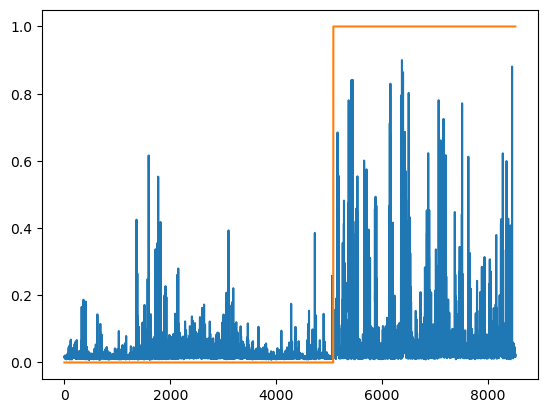

In [21]:
plt.plot(Y_pred)
plt.plot(VALID_target)

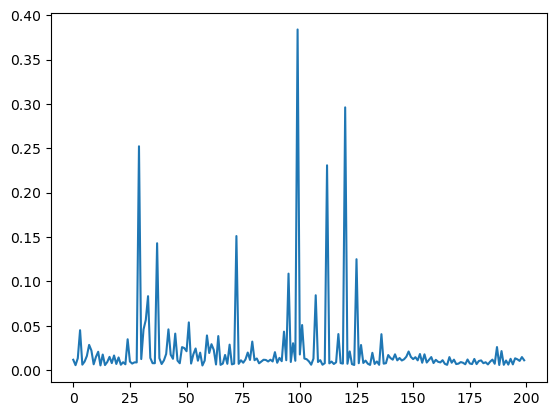

In [25]:
plt.plot(Y_pred[2000:2200])

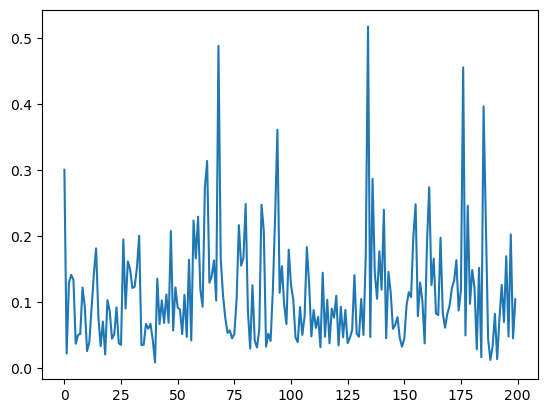

In [36]:
plt.plot(Y_pred[-200:])

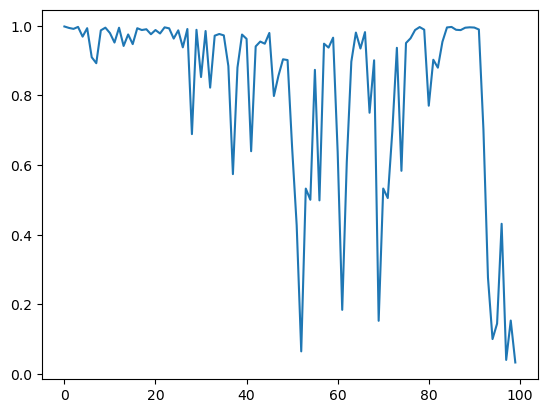

In [71]:
plt.plot(Y_pred[-100:])

In [31]:
Y_pred = model.predict([TESTv4_input_64])
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1

Y_pred = 1/(1 + np.exp(-Y_pred))

record_temp = verif_metric(TESTv4_target, Y_pred)

0.10501852837890428


In [32]:
record_temp

0.10501852837890428